In [16]:
!git clone --recurse-submodules https://github.com/cvg/DeepLSD.git
!cd DeepLSD
!mkdir weights
!wget https://www.polybox.ethz.ch/index.php/s/FQWGkH57UNTqlJZ/download -O weights/deeplsd_wireframe.tar
!wget https://www.polybox.ethz.ch/index.php/s/XVb30sUyuJttFys/download -O weights/deeplsd_md.tar
!bash quickstart_install.sh

Submodule path 'line_refinement/pybind11': checked out 'a18c10f6909dfb2c44be04e2a252c3388ddd6416'
Submodule path 'third_party/homography_est': checked out '30dc1a983db7efe68524ebe23cec3f9124173146'
Submodule path 'third_party/homography_est/pybind11': checked out '06003e82b3ff48337b71b310b46c3d8b15ca6d5a'
Submodule path 'third_party/progressive-x': checked out 'b6ddb94bb332e21a98903585eb85719c608c1bae'
Submodule path 'third_party/progressive-x/graph-cut-ransac': checked out 'fb628fa5f18ef5369c07291c709fde6f1cec23ac'
Submodule path 'third_party/pytlbd': checked out 'b0c8cfcec43ff3267804e5cdd32c9697f4f2040d'
Submodule path 'third_party/pytlbd/googletest': checked out 'e2239ee6043f73722e7aa812a459f54a28552929'
Submodule path 'third_party/pytlbd/pybind11': checked out '4c7697dbe973ed01ae6fbec37d186ebd05982e1f'
Submodule path 'third_party/pytlsd': checked out '21381ca4c5c8da297ef44ce07dda115075c5a648'
Submodule path 'third_party/pytlsd/pybind11': checked out '8de7772cc72daca8e947b79b83fea46

Cloning into 'DeepLSD'...
Submodule 'line_refinement/pybind11' (https://github.com/pybind/pybind11) registered for path 'line_refinement/pybind11'
Submodule 'third_party/homography_est' (https://github.com/rpautrat/homography_est.git) registered for path 'third_party/homography_est'
Submodule 'third_party/progressive-x' (https://github.com/danini/progressive-x.git) registered for path 'third_party/progressive-x'
Submodule 'third_party/pytlbd' (https://github.com/iago-suarez/pytlbd.git) registered for path 'third_party/pytlbd'
Submodule 'third_party/pytlsd' (https://github.com/iago-suarez/pytlsd.git) registered for path 'third_party/pytlsd'
Cloning into 'C:/Users/ASUS/Documents/GitHub/Streamlit-video-process/DeepLSD/line_refinement/pybind11'...
Cloning into 'C:/Users/ASUS/Documents/GitHub/Streamlit-video-process/DeepLSD/third_party/homography_est'...
Cloning into 'C:/Users/ASUS/Documents/GitHub/Streamlit-video-process/DeepLSD/third_party/progressive-x'...
Cloning into 'C:/Users/ASUS/Doc

In [1]:
import numpy as np
import torch
import largestinteriorrectangle as lir
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator

In [2]:
import os
import gc
import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from typing import List, Tuple
from numpy.typing import NDArray
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as lsc
import torch
from deeplsd.utils.tensor import batch_to_device
from deeplsd.models.deeplsd_inference import DeepLSD
from deeplsd.geometry.viz_2d import plot_images, plot_lines
from PIL import Image, ImageFilter

[06/19/2024 09:17:48 INFO] Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[06/19/2024 09:17:48 INFO] NumExpr defaulting to 8 threads.


In [3]:
USE_DEPTHMAP = True  # True: use depthmap, False: automatically detect

# Define paths to SAM checkpoints,
# "sam_vit_b" is the base model,
# "sam_vit_l" is the large model,
# "sam_vit_h" is the huge model,
# read README.md in folder /SAM for more information
RUNTIME_ENV = "colab"  # "colab" or "local"
SAM_CKPT_B = "sam_vit_b_01ec64.pth" if RUNTIME_ENV == "colab" else "sam/sam_vit_b_01ec64.pth"
SAM_CKPT_L = "sam_vit_l_0b3195.pth" if RUNTIME_ENV == "colab" else "sam/sam_vit_l_0b3195.pth"
SAM_CKPT_H = "sam_vit_h_4b8939.pth" if RUNTIME_ENV == "colab" else "sam/sam_vit_h_4b8939.pth"

# Select SAM model type
MODEL_TYPE = "vit_h"
MODEL_WEIGHTS = SAM_CKPT_H

# Set target ratio of black area in binarized images
TARGET_RATIO = 60

In [4]:
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator

In [5]:
import os

download_link = {
    SAM_CKPT_B: "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth",
    SAM_CKPT_L: "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth",
    SAM_CKPT_H: "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth",
}

if not os.path.exists(MODEL_WEIGHTS):
  !wget {download_link[MODEL_WEIGHTS]} -O {MODEL_WEIGHTS}
  
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load SAM model
SAM = sam_model_registry[MODEL_TYPE](checkpoint=MODEL_WEIGHTS)
SAM.to(device=DEVICE)

# Select SAM predictor
PREDICTOR = SamPredictor(SAM) if USE_DEPTHMAP else SamAutomaticMaskGenerator(SAM)

## Function

In [6]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [7]:
def classify_lines_with_slope(out: dict) -> Tuple[NDArray[np.float32], NDArray[np.float32]]:
    lines = out['lines'][0]
    x1, y1 = lines[:, 0, 0], lines[:, 0, 1]
    x2, y2 = lines[:, 1, 0], lines[:, 1, 1]

    vertical_mask = x2 == x1
    slopes = np.where(vertical_mask, np.Infinity, (y2 - y1) / (x2 - x1))
    horizontal_mask = np.abs(slopes) <= 1

    vertical_lines = lines[vertical_mask | ~horizontal_mask]
    horizontal_lines = lines[horizontal_mask]

    return horizontal_lines, vertical_lines


## Generate Segmentation with Bounding Box

SupervisionWarnings: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.22.0`. Use `Color.RED` instead.
SupervisionWarnings: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.22.0`. Use `Color.RED` instead.
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


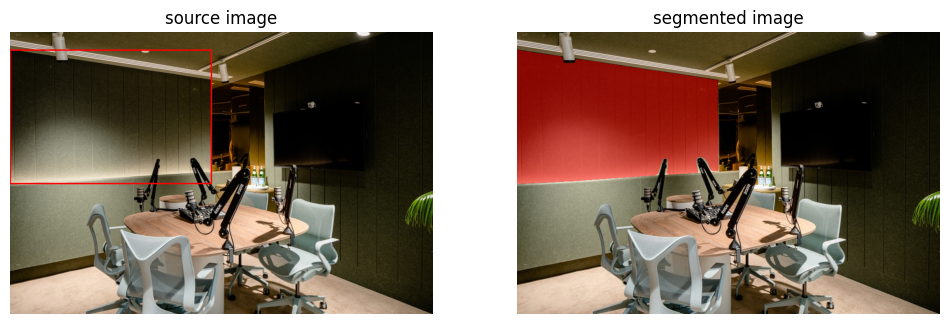

In [8]:
import cv2
import numpy as np
import supervision as sv
import numpy as np
from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image('recording_room.jpg')
widget

mask_predictor = SamPredictor(SAM)
# default_box is going to be used if you will not draw any box on image above
points = [(2, 37), (430, 295), (427, 104), (0, 323)]

# 分别找到最小和最大的x, y值
min_x = min(point[0] for point in points)
min_y = min(point[1] for point in points)
max_x = max(point[0] for point in points)
max_y = max(point[1] for point in points)

# 计算宽度和高度
width = max_x - min_x
height = max_y - min_y

# 生成 default_box
default_box = {'x': min_x, 'y': min_y, 'width': width, 'height': height, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

image_bgr = cv2.imread('recording_room.jpg')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [9]:
coordinates = np.argwhere(masks == 1)

In [10]:
coordinates

array([[  0,  39,   2],
       [  0,  39,   3],
       [  0,  39,   4],
       ...,
       [  2, 322,  17],
       [  2, 322,  18],
       [  2, 322,  19]], dtype=int64)

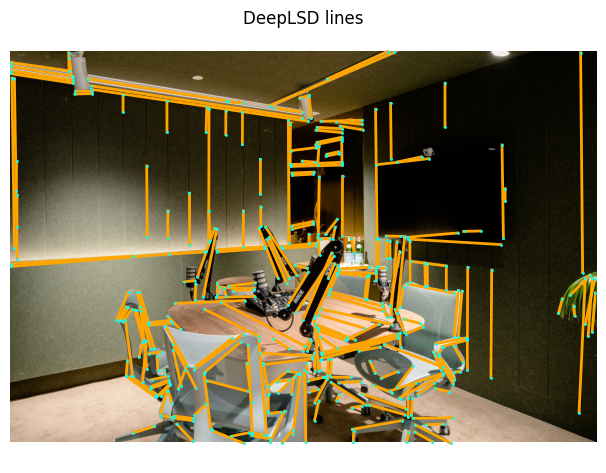

In [11]:
# Load an image
img = cv2.imread('recording_room.jpg')[:, :, ::-1]
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Model config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
conf = {
    'detect_lines': True,  # Whether to detect lines or only distance field/angle field
    'line_detection_params': {
        'merge': True,  # Whether to merge close-by lines
        'filtering': True,  # Whether to filter out lines based on the distance field/angle field. Use 'strict' to get an even stricter filtering
        'grad_thresh': 2,
        'grad_nfa': True,  # If True, use the image gradient and the NFA score of LSD to further threshold lines. We recommand using it for easy images, but to turn it off for challenging images (e.g. night, foggy, blurry images)
    }
}

# Load the model
ckpt = 'C:/Users/ASUS/DeepLSD/weights/deeplsd_md.tar'
# ckpt = '/Volumes/Seagate Bac/models/computer_vision/deeplsd/deeplsd_md.tar' # outdoor
# ckpt = '/Volumes/Seagate Bac/models/computer_vision/deeplsd/deeplsd_wireframe.tar' # indoor
ckpt = torch.load(str(ckpt), map_location='cpu')
net = DeepLSD(conf)
net.load_state_dict(ckpt['model'])
net = net.to(device).eval()

# Load an image
img = cv2.imread('recording_room.jpg')[:, :, ::-1]
kernel_sharpening = np.array([[-1,-1,-1], 
                              [-1, 9,-1],
                              [-1,-1,-1]])
sharpened = cv2.filter2D(img,-1,kernel_sharpening)
gray_img = cv2.cvtColor(sharpened, cv2.COLOR_RGB2GRAY)

# Detect (and optionally refine) the lines
inputs = {'image': torch.tensor(gray_img, dtype=torch.float, device=device)[None, None] / 255.}
with torch.no_grad():
    out = net(inputs)
    pred_lines = out['lines'][0]

# Plot the predictions
plot_images([img], ['DeepLSD lines'], cmaps='gray')
plot_lines([pred_lines], indices=range(1))

In [42]:
pred_lines

array([[[391.64276 , 268.23117 ],
        [439.6961  , 342.49084 ]],

       [[394.5873  , 287.62396 ],
        [424.57272 , 355.51376 ]],

       [[381.30658 , 270.42606 ],
        [410.9654  , 347.24115 ]],

       ...,

       [[  9.025417, 213.00029 ],
        [  9.530355, 168.00595 ]],

       [[526.3531  , 599.19684 ],
        [527.35443 , 582.1382  ]],

       [[241.60883 , 285.99152 ],
        [241.8649  , 243.99918 ]]], dtype=float32)

### 擴展5%

In [12]:
import numpy as np
import cv2
from concurrent.futures import ThreadPoolExecutor


# Step 1: Create a binary mask image
height, width = 1024, 1024  # Adjust based on your actual image dimensions
binary_mask = np.zeros((height, width), dtype=np.uint8)
mask_coords = np.argwhere(masks == 1)
for coord in mask_coords:
    binary_mask[coord[1], coord[2]] = 1  # Set the pixels of the mask to 1

# Expand the mask using dilation
kernel_size = int(max(height, width) * 0.05)  # Kernel size as 5% of the dimensions
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
binary_mask = cv2.dilate(binary_mask, kernel)

# Step 2: Define a function to rasterize lines
def rasterize_line(img, line):
    pt1, pt2 = (int(line[0][0]), int(line[0][1])), (int(line[1][0]), int(line[1][1]))
    cv2.line(img, pt1, pt2, color=1, thickness=1)

# Step 3: Check for intersections
line_segments = pred_lines  # Ensure 'pred_lines' is defined as your lines data from DeepLSD
intersecting_lines = []
for line in line_segments:
    line_img = np.zeros_like(binary_mask)
    rasterize_line(line_img, line)
    if np.any(np.logical_and(binary_mask, line_img)):
        intersecting_lines.append(line)

# Output the intersecting lines
print("Intersecting Lines:", intersecting_lines)


Intersecting Lines: [array([[391.64276, 268.23117],
       [439.6961 , 342.49084]], dtype=float32), array([[394.5873 , 287.62396],
       [424.57272, 355.51376]], dtype=float32), array([[381.30658, 270.42606],
       [410.9654 , 347.24115]], dtype=float32), array([[426.89838, 104.00047],
       [427.7829 , 294.001  ]], dtype=float32), array([[  0.8757927, 329.43106  ],
       [301.1315   , 305.66098  ]], dtype=float32), array([[89.56016  ,  1.0060295],
       [89.95782  , 30.014286 ]], dtype=float32), array([[296.17184, 376.03452],
       [317.1369 , 271.6259 ]], dtype=float32), array([[414.95175, 299.54883],
       [469.9641 , 293.66446]], dtype=float32), array([[316.9219 , 303.73026],
       [390.01447, 299.2352 ]], dtype=float32), array([[318.07257, 307.03333],
       [391.055  , 301.80872]], dtype=float32), array([[287.32138, 345.17874],
       [313.77814, 270.63104]], dtype=float32), array([[397.91037, 284.562  ],
       [428.3788 , 347.89337]], dtype=float32), array([[124.63216 ,

### 原始

In [13]:
import numpy as np
import cv2

##Step 1: Create a binary mask image
height, width = 1024, 1024 # Adjust based on your actual image dimensions
binary_mask = np.zeros((height, width), dtype=np.uint8)
mask_coords = np.argwhere(masks == 1)
for coord in mask_coords:
    binary_mask[coord[1], coord[2]] = 1 # Set the pixels of the mask to 1

##Step 2: Define a function to rasterize lines
def rasterize_line(img, line):
    pt1, pt2 = (int(line[0][0]), int(line[0][1])), (int(line[1][0]), int(line[1][1]))
    cv2.line(img, pt1, pt2, color=1, thickness=1)

##Step 3: Check for intersections
line_segments = pred_lines
intersecting_lines = []
for line in line_segments:
    line_img = np.zeros_like(binary_mask)
    rasterize_line(line_img, line)
    if np.any(np.logical_and(binary_mask, line_img)):
        intersecting_lines.append(line)

##Output the intersecting lines
print("Intersecting Lines:", intersecting_lines)

Intersecting Lines: [array([[381.30658, 270.42606],
       [410.9654 , 347.24115]], dtype=float32), array([[426.89838, 104.00047],
       [427.7829 , 294.001  ]], dtype=float32), array([[316.9219 , 303.73026],
       [390.01447, 299.2352 ]], dtype=float32), array([[124.63216 ,  57.498013],
       [456.7923  , 106.41059 ]], dtype=float32), array([[304.5976 , 243.96968],
       [306.87756, 288.90472]], dtype=float32), array([[  6.2362027,  40.965977 ],
       [ 10.596194 , 317.9754   ]], dtype=float32), array([[209.42235, 175.00345],
       [210.0738 , 284.00552]], dtype=float32), array([[357.73184, 300.0023 ],
       [357.90613, 243.99971]], dtype=float32), array([[  0.95315385, 325.2517    ],
       [187.97142   , 313.54358   ]], dtype=float32), array([[240.44981,  75.99889],
       [240.56525, 123.00107]], dtype=float32), array([[304.61646, 292.00333],
       [305.03488,  88.00007]], dtype=float32), array([[356.3216 , 142.00119],
       [356.50262,  92.99816]], dtype=float32), array([

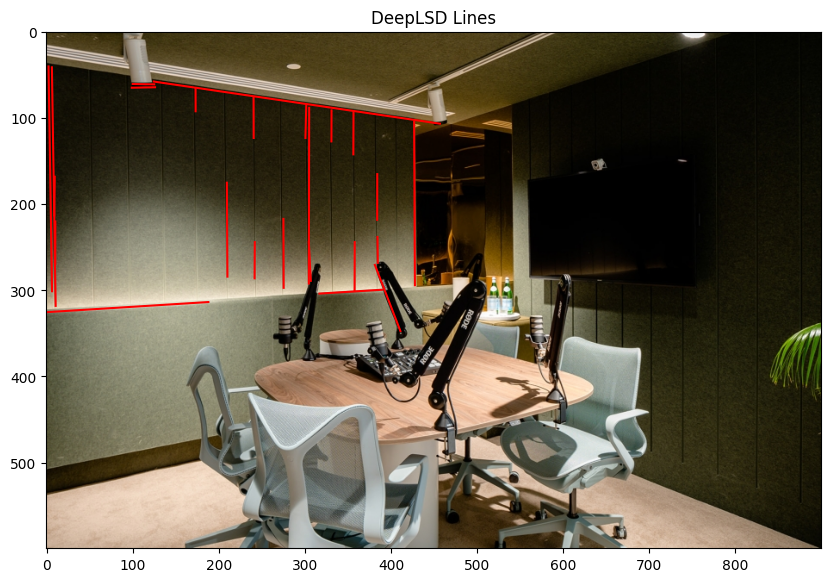

In [14]:
plt.figure(figsize=(10, 8))
plt.imshow(img, cmap='gray')  # Display the background image

# Plot each line segment
for line in intersecting_lines:
    plt.plot([line[0][0], line[1][0]], [line[0][1], line[1][1]], 'r-')  # Red lines

plt.title('DeepLSD Lines')
plt.show()

### 找出水平線

In [60]:
def classify_lines_with_slope(out: list) -> Tuple[NDArray[np.float32], NDArray[np.float32]]:
    lines = out
    x1, y1 = lines[:, 0, 0], lines[:, 0, 1]
    x2, y2 = lines[:, 1, 0], lines[:, 1, 1]

    vertical_mask = x2 == x1
    slopes = np.where(vertical_mask, np.Infinity, (y2 - y1) / (x2 - x1))
    horizontal_mask = np.abs(slopes) <= 1

    vertical_lines = lines[vertical_mask | ~horizontal_mask]
    horizontal_lines = lines[horizontal_mask]

    return horizontal_lines, vertical_lines


In [70]:
combined_array = np.empty((0, 2, 2))

for line in intersecting_lines:
    new_line_array = np.array([[line[0][0], line[0][1]], [line[1][0], line[1][1]]])
    combined_array = np.append(combined_array, [new_line_array], axis=0)

In [71]:
h_line, v_line = classify_lines_with_slope(combined_array)

In [72]:
h_line

array([[[316.92190552, 303.73025513],
        [390.01446533, 299.23519897]],

       [[124.63215637,  57.49801254],
        [456.79229736, 106.41059113]],

       [[  0.95315385, 325.25170898],
        [187.97142029, 313.5435791 ]],

       [[100.02787781,  60.32193756],
        [125.02098083,  60.73715973]],

       [[ 98.9930191 ,  64.63672638],
        [126.02146912,  64.11727905]]])

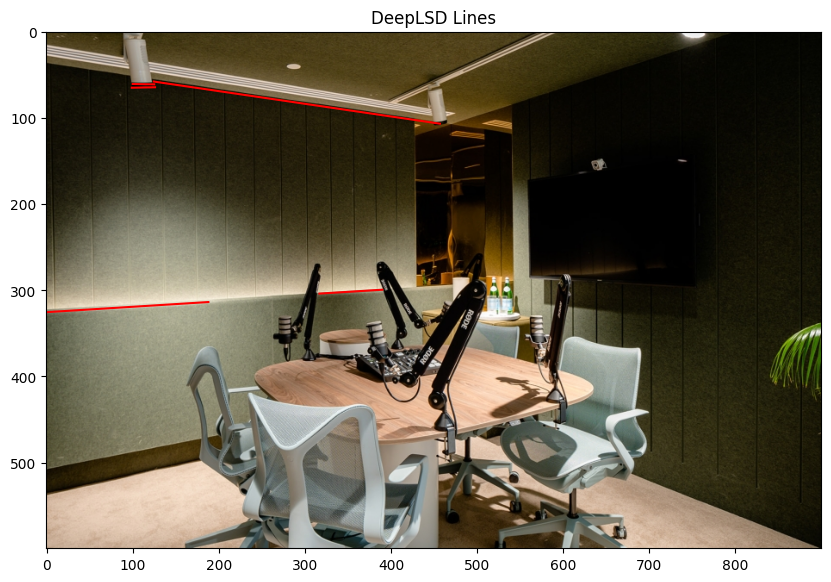

In [76]:
plt.figure(figsize=(10, 8))
plt.imshow(img, cmap='gray')  # Display the background image

# Plot each line segment
for line in h_line:
    plt.plot([line[0][0], line[1][0]], [line[0][1], line[1][1]], 'r-')  # Red lines

plt.title('DeepLSD Lines')
plt.show()

In [78]:
def line_length(line):
    return np.linalg.norm(line[1] - line[0])

# Compute the lengths of each line
line_lengths = [(line, line_length(line)) for line in h_line]

# Sort the lines by length in descending order
sorted_lines = sorted(line_lengths, key=lambda x: x[1], reverse=True)

# Get the two longest lines
longest_lines = sorted_lines[:2]

# Extract the line coordinates from the result
h_lines = [line[0] for line in longest_lines]

print("兩條最長的線:")
for i, line in enumerate(h_lines, 1):
    print(f"Line {i}: {line} with length {line_length(line)}")

兩條最長的線:
Line 1: [[124.63215637  57.49801254]
 [456.79229736 106.41059113]] with length 335.74216239089805
Line 2: [[  0.95315385 325.25170898]
 [187.97142029 313.5435791 ]] with length 187.38439712891085


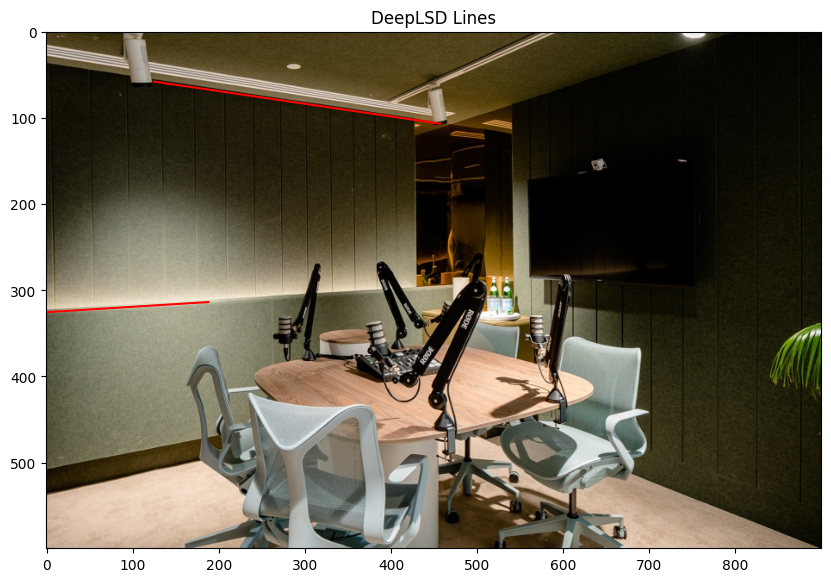

In [80]:
plt.figure(figsize=(10, 8))
plt.imshow(img, cmap='gray')  # Display the background image

# Plot each line segment
for line in h_lines:
    plt.plot([line[0][0], line[1][0]], [line[0][1], line[1][1]], 'r-')  # Red lines

plt.title('DeepLSD Lines')
plt.show()

In [82]:
import numpy as np

def compute_vanishing_point(line1, line2):
    # 轉換線段到直線方程式的參數形式 Ax + By + C = 0
    def line_params(p1, p2):
        A = p1[1] - p2[1]
        B = p2[0] - p1[0]
        C = p1[0] * p2[1] - p2[0] * p1[1]
        return A, B, -C

    # 提取兩條線的端點
    x1, y1 = line1[0]
    x2, y2 = line1[1]
    x3, y3 = line2[0]
    x4, y4 = line2[1]

    # 計算直線方程式的參數
    A1, B1, C1 = line_params((x1, y1), (x2, y2))
    A2, B2, C2 = line_params((x3, y3), (x4, y4))

    # 建立係數矩陣和常數向量
    A = np.array([[A1, B1], [A2, B2]])
    C = np.array([C1, C2])

    # 解方程組 Ax = -C
    try:
        point = np.linalg.solve(A, -C)
    except np.linalg.LinAlgError:
        # 如果矩陣不可逆，說明兩條線是平行的，沒有交點
        return None

    return point

# 示例線段
line1 = np.array(h_lines[0], dtype=np.float32)
line2 = np.array(h_lines[1], dtype=np.float32)

# 計算消失點
vanishing_point = compute_vanishing_point(line1, line2)
if vanishing_point is not None:
    print(f"消失點坐標: {vanishing_point}")
else:
    print("兩條線平行，沒有交點")

消失點坐標: [-1363.604    -239.94405]


### 調整圖片